In [1]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

from sacrebleu.metrics import BLEU

d:\10_python\python-3.8.2\python\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
print(torch.__version__)

2.0.0+cpu


In [3]:
# data set

from datasets import load_dataset

dataset = load_dataset('silicone', 'dyda_da', split='train[:1000]')

Found cached dataset silicone (C:/Users/savou/.cache/huggingface/datasets/silicone/dyda_da/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5)


In [4]:
dataset

Dataset({
    features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
    num_rows: 1000
})

In [5]:
print(dataset['Label'].count(0))
print(dataset['Label'].count(1))
print(dataset['Label'].count(2))
print(dataset['Label'].count(3))

71
98
529
302


In [6]:
tok = TweetTokenizer()

# an example of tokenization
example = dataset[2]['Utterance']
tokens = tok.tokenize(example.lower().strip())
print(tokens)

['what', 'do', 'you', 'mean', '?', 'it', 'will', 'help', 'us', 'to', 'relax', '.']


In [7]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vectors = FastText(language='en')

In [8]:
pretrained_vectors.vectors.size()

torch.Size([2519370, 300])

In [9]:
pretrained_vocab = vocab(pretrained_vectors.stoi)

In [10]:
unk_token = "<unk>"
unk_index = 1

pad_token = '<pad>'
pad_index = 0

pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)

In [11]:
# this is necessary otherwise it will throw runtime error 
# if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),
                                   pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [12]:
def tokenize(example, stoi, max_length):
    
    text = []
    for token in tok.tokenize(example.lower().strip()):
        if token in stoi:
            text.append(stoi[token])
        else:
            text.append(stoi['<unk>'])
    
    padded_text = None
    if len(text) < max_length:
        padded_text = text + [stoi['<pad>'] for i in range(len(text), max_length)]
    elif len(text) > max_length:
        padded_text = text[:max_length]
    else:
        padded_text = text
    return padded_text  
  

def tokenize_all(examples, stoi):
    
    result = {}
    
    result['Utterance'] = [tokenize(example, stoi, max_length=20) \
                           for example in examples['Utterance']]
    result['Dialogue_Act'] = examples['Dialogue_Act']
    result['Dialogue_ID'] = examples['Dialogue_ID']
    result['Label'] = examples['Label']
    
    return result


In [13]:
dataset_study = {'train': dataset,
                 'test': None,
                 'validation:': None}
dataset_study['train'] = dataset_study['train'].map(lambda e: tokenize_all(e, 
                         pretrained_vocab.get_stoi()), 
                         batched=True)

Loading cached processed dataset at C:\Users\savou\.cache\huggingface\datasets\silicone\dyda_da\1.0.0\af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5\cache-e1919db4d3391d19.arrow


In [14]:
# show the example
print(dataset_study['train']['Utterance'][:2])

[[591, 2, 1817, 2, 243, 78, 667, 18, 13, 431, 17979, 66, 6186, 57, 0, 0, 0, 0, 0, 0], [51, 436, 21, 14, 38177, 42, 14, 660, 33, 279, 18, 622, 7593, 1, 0, 0, 0, 0, 0, 0]]


In [15]:
from sklearn.model_selection import train_test_split

# we divde the dataset on the training set of the original data
indices = [i for i in range(len(dataset_study['train']))]

# 67% train
# 16% validation
# 16% testing

train_indices, other_indices, _, _ = train_test_split(indices, indices, 
                                                      test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, 
                                                   test_size=0.5, random_state=42)

In [16]:
print(len(train_indices), 
      len(val_indices), 
      len(test_indices))

670 165 165


In [17]:
dataset_study['validation'] = dataset_study['train'].select(val_indices)
dataset_study['test'] = dataset_study['train'].select(test_indices)
dataset_study['train'] = dataset_study['train'].select(train_indices)

In [18]:
# show the example
print(dataset_study['validation']['Utterance'][:2])

[[29, 436, 181, 139, 2, 26, 335, 29, 2, 116, 33, 6769, 1, 29, 2, 116, 2492, 76, 29, 919], [139, 2, 29, 134, 6847, 45649, 181, 2, 33, 901, 76, 21, 5096, 2, 409, 1, 0, 0, 0, 0]]


In [19]:
dataset_study

{'train': Dataset({
     features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
     num_rows: 670
 }),
 'test': Dataset({
     features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
     num_rows: 165
 }),
 'validation:': None,
 'validation': Dataset({
     features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
     num_rows: 165
 })}

In [20]:
# create Data Loader

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

class TweetDataset(Dataset):
    
    def __init__(self, data, args):
        self.args = args
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = {
          "Utterance": np.array(self.data[idx]['Utterance']),
          "Label": np.array(self.data[idx]['Label'])
        }
        return item


In [21]:
dataset_study

{'train': Dataset({
     features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
     num_rows: 670
 }),
 'test': Dataset({
     features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
     num_rows: 165
 }),
 'validation:': None,
 'validation': Dataset({
     features: ['Utterance', 'Dialogue_Act', 'Dialogue_ID', 'Label', 'Idx'],
     num_rows: 165
 })}

In [22]:
# load the data into batches

args = {'bsize': 64}

train_loader = DataLoader(TweetDataset(dataset_study['train'], args), 
                          batch_size = args['bsize'], num_workers=0, 
                          shuffle=True, drop_last=True)

val_loader   = DataLoader(TweetDataset(dataset_study['validation'], args), 
                          batch_size=args['bsize'], num_workers=0, 
                          shuffle=True, drop_last=True)

test_loader  = DataLoader(TweetDataset(dataset_study['test'], args), 
                          batch_size=args['bsize'], num_workers=0, 
                          shuffle=True, drop_last=True)

In [23]:
# model

class Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, mlp_size, class_size):
        
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.class_size = class_size
        self.mlp_size = mlp_size
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        
        self.decoders = nn.TransformerDecoderLayer(d_model = hidden_size,nhead = 10)
        
        self.out = nn.Linear(in_features = hidden_size, 
                             out_features = output_size)
        
        self.linear = nn.Linear(output_size, mlp_size)
        # self.gru = nn.GRU(mlp_size, mlp_size)
        self.linear2 = nn.Linear(mlp_size, mlp_size)
        self.linear3 = nn.Linear(mlp_size, class_size)
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)
    
    #  methods 
    def forward(self, x):
        
        embedded = self.embedding(x)
        
        for i in range(12):
            embedded= self.decoders(embedded, embedded)
            
        output = self.out(embedded)
        size=output.size()
        size=size[0]*size[1]
        output = output.reshape(size)
        
        out2 = nn.Linear(size, output_size)
        output = out2(output)
        
        output = self.softmax(output.unsqueeze(dim=0))
        
        output = self.linear(output)
        output = self.relu(output)
        
        output = self.linear2(output)
        output = self.relu(output)
        
        output = self.linear3(output)
        output = self.softmax(output.squeeze(dim=0).unsqueeze(dim=0))
        
        return output

In [24]:
from sklearn.utils import class_weight

y = torch.tensor(dataset_study['train']['Label'])
class_weights=class_weight.compute_class_weight('balanced',np.unique(y),y.numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)

d:\10_python\python-3.8.2\python\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2 3], y=[3 3 3 2 1 2 2 2 3 2 3 2 2 2 2 2 3 2 3 2 3 3 3 2 2 1 3 2 2 1 2 2 3 3 3 2 2
 3 1 0 2 3 0 3 0 2 2 3 3 3 2 0 3 2 3 1 3 2 3 2 2 2 3 1 2 2 2 2 2 2 2 3 2 2
 2 3 3 2 2 2 3 3 2 1 2 2 2 0 3 2 3 3 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3
 2 3 2 2 3 3 2 1 2 2 2 2 2 2 2 2 1 2 2 2 0 2 1 2 2 1 3 2 3 3 2 2 2 3 3 1 3
 2 2 3 2 2 2 2 2 3 2 2 2 1 2 3 2 3 1 3 2 3 3 2 2 3 2 2 2 2 2 2 2 1 3 2 2 3
 2 3 3 1 2 3 3 3 2 3 2 3 3 2 2 2 3 3 2 1 3 2 2 3 3 2 2 2 0 0 1 2 3 2 3 1 2
 2 3 3 2 2 3 2 3 1 2 2 1 0 2 2 3 2 3 2 2 2 2 3 2 2 3 3 2 2 2 0 3 1 3 2 2 2
 2 2 1 2 3 1 3 2 2 2 2 2 2 1 1 3 2 2 0 3 2 2 2 3 2 2 2 2 2 0 3 3 2 1 3 3 2
 2 2 2 2 2 3 0 3 3 2 2 2 3 2 2 3 3 2 2 2 3 1 2 0 2 3 2 2 2 0 0 2 3 3 2 0 2
 2 0 2 2 3 1 2 3 3 2 3 0 3 3 2 2 3 2 0 2 1 0 3 0 2 0 1 2 2 2 0 0 1 2 2 2 2
 2 1 2 3 3 2 2 2 3 3 1 3 2 2 3 2 3 1 2 2 2 2 2 2 0 2 2 0 2 1 2 3 2 3 2 3 3
 1 3 3 2 2 0 3 2 0 3 3 1 1 2 1 2 2 3 2 2 2 3 3 1 3 

In [32]:
# training function

def train(batch, model, optimizer, epoch, class_weights):
    
    model.train()
    # initialize empty lists for losses and accuracies
    loss_iter = list()
    accuracy_iter = list()
        
    batch = {'Utterance': batch['Utterance'].to('cpu'),
             'Label': batch['Label'].to('cpu')}
        
    optimizer.zero_grad()
    
    batch_size = 64
    logits = model(batch['Utterance'][0]).unsqueeze(dim=0)

    for i in range(1, batch_size):
        logit = model(batch['Utterance'][i]).unsqueeze(dim=0)
        logits = torch.cat((logits, logit), 0)
    
    label = torch.tensor(batch['Label'], dtype=torch.long)
    
    cross_entropy_loss = nn.CrossEntropyLoss(weight=class_weights)
    logits = logits.detach()
    logits = torch.tensor(logits, requires_grad=True)
    logits = logits.squeeze(dim=1)
    loss = cross_entropy_loss(logits, label)
    loss.backward()
    optimizer.step()
    
    loss_iter.append(loss.item())
    
    # calculate the accuracy
    _, tag_seq  = torch.max(logits, 1)
    correct = (tag_seq.flatten() == batch['Label'].flatten()).float().sum()
    accuracy = correct / batch['Label'].flatten().size(0)
    accuracy_iter.append(accuracy.item())
  
    # simple averages of losses for this epoch
    loss_iter_avg = sum(loss_iter)/len(loss_iter)
    accuracy_it_avg = sum(accuracy_iter)/len(accuracy_iter)
    
    return loss_iter_avg, accuracy_it_avg

In [26]:
# start training

import torch.optim as optim

def run_epochs(transformer, max_epochs, learning_rate=0.001,limit=0,class_weights=class_weights):    
    
    optimizer = optim.AdamW(transformer.parameters(), 
                          lr=learning_rate)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(max_epochs):
        
        # training
        it_losses = []
        it_accuracies = []
        
        total = train_loader.__len__()
        # allow to limit the number of random samples per epoch
        if limit > 0: 
            total = limit
        
        for iter, batch in tqdm(enumerate(train_loader), 
                                desc="Epoch %s:" % (epoch), 
                                total=total):
            # trigger the limit if it is set
            if limit > 0 and iter >= limit: 
                break

            loss, accuracy = train(batch, transformer, optimizer, epoch, class_weights)
            
            it_losses.append(loss)
            it_accuracies.append(accuracy)

        epoch_loss = sum(it_losses)/len(it_losses)
        epoch_accuracy = sum(it_accuracies)/len(it_accuracies)
    
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        print("Epoch %s : %s : (%s %s) (%s %s)" % (colored(str(epoch), 'blue'), 
                                        colored('Training', 'blue'), 
                                        colored('loss', 'cyan'), epoch_loss,
                                        colored('accuracy', 'cyan'),epoch_accuracy))
      
    return epoch_losses,epoch_accuracies 


In [27]:
# inference function

def inference(target, model, loader, limit=0,class_weights=class_weights):
    
    model.eval()
    
    loss_iter = []
    accuracy_iter = []
    
    value_predict = []
    value_real = []

    total = loader.__len__()
    if limit > 0: 
        total = limit

    for iter, batch in tqdm(enumerate(loader), 
                            desc="%s:" % (target), 
                            total=total):
        if limit > 0 and it >= limit: 
            break

        with torch.no_grad():

            batch_size = 64
            logits = model(batch['Utterance'][0]).unsqueeze(dim=0)

            for i in range(1, batch_size):
                logit = model(batch['Utterance'][i]).unsqueeze(dim=0)
                logits = torch.cat((logits, logit), 0)
    
            label = torch.tensor(batch['Label'], dtype=torch.long)
    
            cross_entropy_loss = nn.CrossEntropyLoss(weight=class_weights)
            logits = logits.detach()
            logits = torch.tensor(logits, requires_grad=True)
            logits = logits.squeeze(dim=1)
            loss = cross_entropy_loss(logits, label)
            
            loss_iter.append(loss.item())
            
            # calculate the accuracy
            _, tag_seq  = torch.max(logits, 1)
            correct = (tag_seq.flatten() == batch['Label'].flatten()).float().sum()
            accuracy = correct / batch['Label'].flatten().size(0)
            accuracy_iter.append(accuracy.item())
      
            # extend
            value_predict.extend(tag_seq.cpu().detach().tolist())
            value_real.extend(batch['Label'].cpu().detach().tolist())

    # compute the average loss and accuracy 
    loss_iter_avg = sum(loss_iter)/len(loss_iter)
    accuracy_iter_avg = sum(accuracy_iter)/len(accuracy_iter)
  
    # print useful information. 
    print("%s : (%s %s) (%s %s)" % (colored(target, 'blue'), 
                                    colored('loss', 'cyan'), 
                                    sum(loss_iter)/len(loss_iter), 
                                    colored('acc', 'cyan'), 
                                    sum(accuracy_iter) / len(accuracy_iter)))

    # return
    return value_real, value_predict,loss_iter_avg,\
           accuracy_iter_avg, loss_iter, accuracy_iter

In [28]:
input_size=20
hidden_size=300
output_size=64
mlp_size=8
class_size=4
epochs = 5

model = Model(input_size,hidden_size, 
              output_size, mlp_size,class_size)

In [29]:
# example
tensor = torch.tensor(dataset_study['train'][2]['Utterance'])
tensor = model(tensor)

In [33]:
output = torch.tensor(dataset_study['train'][1]['Utterance'])
model = Model(input_size,hidden_size, output_size, mlp_size,class_size)
model(output)

tensor([[0.2539, 0.2904, 0.1599, 0.2959]], grad_fn=<SoftmaxBackward0>)

In [34]:
model = Model(input_size,hidden_size, output_size, mlp_size,class_size)
loss_list, accuracy_list = run_epochs(model, epochs, 
                                      learning_rate=0.01,  
                                      limit=0,
                                      class_weights=class_weights)

Epoch 0::   0%|                                                                                 | 0/10 [00:00<?, ?it/s]<ipython-input-32-87933517389d>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch['Label'], dtype=torch.long)
<ipython-input-32-87933517389d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(logits, requires_grad=True)
Epoch 0:: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.50s/it]


Epoch 0 : Training : (loss 1.3867566466331482) (accuracy 0.5203125)


Epoch 1:: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.54s/it]


Epoch 1 : Training : (loss 1.3858017325401306) (accuracy 0.525)


Epoch 2:: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.59s/it]


Epoch 2 : Training : (loss 1.3867583632469178) (accuracy 0.51875)


Epoch 3:: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.63s/it]


Epoch 3 : Training : (loss 1.3867487549781798) (accuracy 0.5234375)


Epoch 4:: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.66s/it]

Epoch 4 : Training : (loss 1.3862419247627258) (accuracy 0.5203125)


In [200]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
    
    plt.plot(range(len(loss_list)), loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('lr: {}, optim_alg:{}'.format(0.01, 'Adam'))
    plt.show()

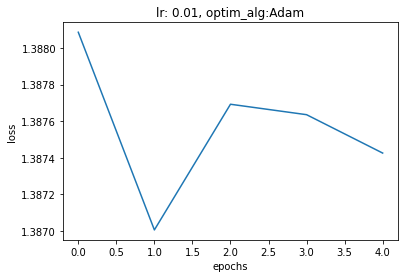

In [201]:
plot_loss(loss_list)

In [204]:
def plot_accuracy(accuracy_list):
    
    plt.plot(range(len(accuracy_list)), accuracy_list)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('lr: {}, optim_alg:{}'.format(0.01, 'Adam'))
    plt.show()

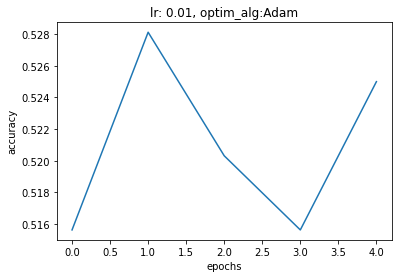

In [205]:
plot_accuracy(accuracy_list)

In [206]:
value_real, value_predict,loss_iter_avg,\
accuracy_iter_avg, loss_iter, accuracy_iter = inference("test",
                                                        model,
                                                        test_loader)

test::   0%|                                                                                     | 0/2 [00:00<?, ?it/s]<ipython-input-187-2d1ac5369275>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch['Label'], dtype=torch.long)
<ipython-input-187-2d1ac5369275>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(logits, requires_grad=True)
test:: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.93s/it]

test : (loss 1.3821804523468018) (acc 0.5546875)


In [35]:
value_real, value_predict,loss_iter_avg,\
accuracy_iter_avg, loss_iter, accuracy_iter = inference("validation",
                                                        model,
                                                        test_loader)

validation::   0%|                                                                               | 0/2 [00:00<?, ?it/s]<ipython-input-27-2d1ac5369275>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch['Label'], dtype=torch.long)
<ipython-input-27-2d1ac5369275>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(logits, requires_grad=True)
validation:: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.84s/it]

validation : (loss 1.3817933797836304) (acc 0.6015625)


In [37]:
# example table

from sklearn.metrics import confusion_matrix
#confusion_matrix(np.array(value_real).flatten(), np.array(value_predict).flatten())

In [41]:
model.named_parameters

<bound method Module.named_parameters of Model(
  (embedding): Embedding(2519371, 300)
  (decoders): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (linear1): Linear(in_features=300, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=300, bias=True)
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (out): Linear(in_features=300, out_features=64, bias=True)
  (l

In [46]:
pp=0
for p in list(model.parameters()):
    nn=1
    for s in list(p.size()):
        nn = nn*s
        pp += nn

In [47]:
pp

760310743